In [34]:
from latools import *

%matplotlib inline

idx = pd.IndexSlice

In [2]:
dataformat = {'genfromtext_args': {'delimiter': ',',
                                   'skip_header': 16},
              'column_id': {'name_row': 13,
                            'delimiter': ',',
                            'timecolumn': 0,
                            'pattern': '([0-9]{1,3}[A-z]{1,2})'},
              'meta_regex': {0: (['name', 'date'],
                                 '(.*?):(.*);')}
             }



## Cleaning Test - RUN1

In [3]:
dat = analyse('test_data/Aleksey/Cleaning test/RUN1', dataformat=dataformat, 
              internal_standard='43Ca', names='metadata_names', srm_identifier='NIST')

latools analysis using "DEFAULT" configuration:
  225 Data Files Loaded: 25 standards, 200 samples
  Analytes: 11B 24Mg 25Mg 27Al 43Ca 55Mn 57Fe 63Cu 66Zn 88Sr
  Internal Standard: 43Ca


Calculating exponential decay coefficient
from SRM 43Ca washouts...
  -1.18


Despiking: 100%|██████████| 225/225 [00:05<00:00, 38.85it/s]


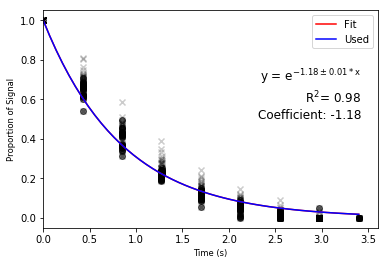

In [4]:
dat.despike(autorange_kwargs={'d_mult': 1., 'gwin': 7}, exponentplot=True)

In [5]:
dat.autorange(d_mult=1., gwin=5, on_mult=[1,.5], off_mult=[.5,4], thresh_n=3)

AutoRange: 100%|██████████| 225/225 [00:11<00:00, 19.19it/s]


In [6]:
dat.bkg_calc_weightedmean(weight_fwhm=300, n_min=35, n_max=70, cstep=100)

Calculating Analyte Backgrounds: 100%|██████████| 10/10 [00:43<00:00,  4.10s/it]


In [7]:
# fig, ax = dat.bkg_plot()

In [8]:
dat.bkg_subtract()

Background Subtraction: 100%|██████████| 225/225 [00:14<00:00, 17.01it/s]


In [9]:
dat.ratio()

Ratio Calculation: 100%|██████████| 225/225 [00:01<00:00, 183.54it/s]


In [10]:
dat.calibrate(srms_used=['NIST610', 'NIST612'])

/Users/oscarbranson/anaconda/envs/py3/lib/python3.5/site-packages/scipy/odr/odrpack.py:394: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)
Calibration: 100%|██████████| 225/225 [00:05<00:00, 42.02it/s]


In [11]:
# fig, ax = dat.calibration_plot()

In [12]:
# fig, axs = dat.crossplot()

In [81]:
dat.filter_clear()
dat.filter_threshold('27Al', 100e-6)
dat.filter_threshold('55Mn', 0.1e-3)
dat.filter_threshold('57Fe', 1e-3)
dat.filter_threshold('24Mg', 5e-3)
dat.filter_threshold('66Zn', 150e-6)
dat.filter_on('below')

Threshold Filter: 100%|██████████| 200/200 [00:00<00:00, 5422.40it/s]


Subset: All Samples

n  Filter Name          11B    24Mg   25Mg   27Al   43Ca   55Mn   57Fe   63Cu   66Zn   88Sr   
0  27Al_thresh_below    True   True   True   True   True   True   True   True   True   True   
1  27Al_thresh_above    False  False  False  False  False  False  False  False  False  False  
2  55Mn_thresh_below    True   True   True   True   True   True   True   True   True   True   
3  55Mn_thresh_above    False  False  False  False  False  False  False  False  False  False  
4  57Fe_thresh_below    True   True   True   True   True   True   True   True   True   True   
5  57Fe_thresh_above    False  False  False  False  False  False  False  False  False  False  
6  24Mg_thresh_below    True   True   True   True   True   True   True   True   True   True   
7  24Mg_thresh_above    False  False  False  False  False  False  False  False  False  False  
8  66Zn_thresh_below    True   True   True   True   True   True   True   True   True   True   
9  66Zn_thresh_above    False

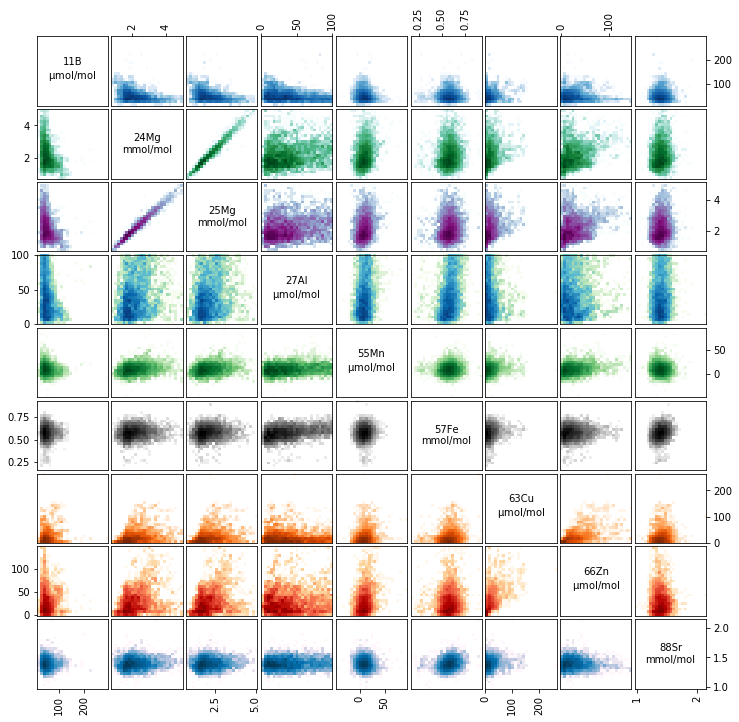

In [83]:
fig, axs = dat.crossplot(filt=True)

In [84]:
dat.sample_stats(stats=['H15_mean', 'H15_se'])

Calculating Stats: 100%|██████████| 225/225 [00:20<00:00, 10.94it/s]


In [93]:
sd = dat.getstats()

### Re-organise stats to combine repeat ablations of sample

In [94]:
fm = re.compile('(.*-[0-9]{1,2})([a-z]+)')
fms = re.compile('(.*)')

In [95]:
sd.reset_index(inplace=True)

In [96]:
def split(d):
    sample = d.loc[:,'sample'].iloc[0]
    if fm.match(sample):
        name, spot = fm.match(sample).groups()
    else:
        name = fms.match(sample).groups()
        spot = 'a'
    
    d.loc[:, 'sample'] = name
#     d.loc[:, 'n'] = n
    d.loc[:, 'rep'] = spot
    return d

gs = sd.groupby('sample')
sd = gs.apply(split)

In [97]:
df = sd.pivot_table(index=('statistic', 'sample', 'rep'))

In [3]:
# df

### Plot Stats

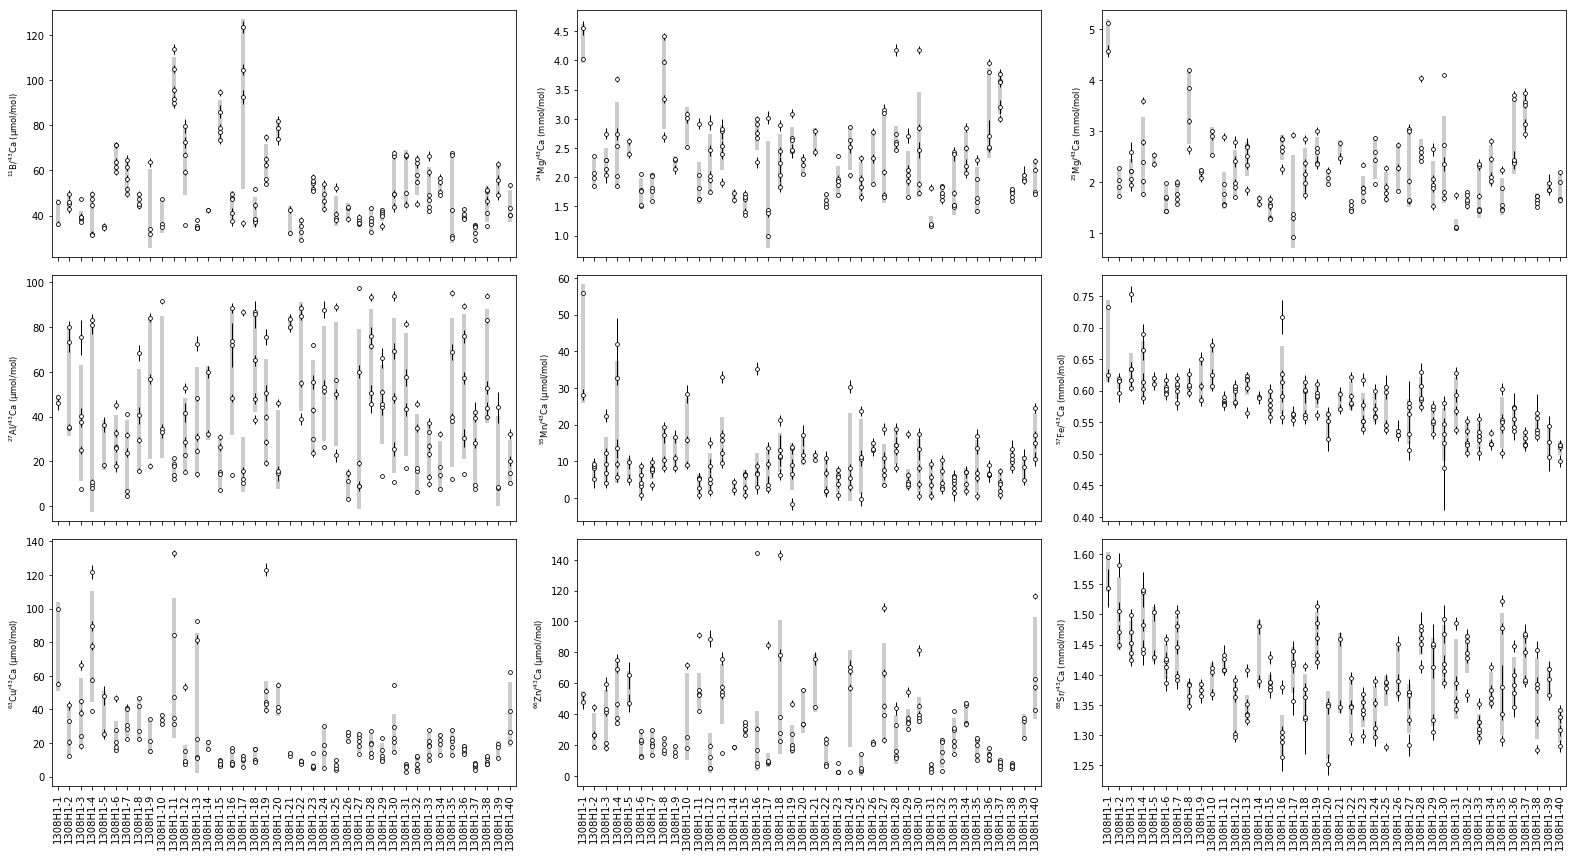

In [127]:
fig, ax = plt.subplots(3,3, figsize=[22,12], sharex=True)

val = 'H15_mean'
err = 'H15_se'

ans = dat.analytes[dat.analytes != dat.internal_standard]

rep = lambda x: x.groups()[0] + '{:02.0f}'.format(int(x.groups()[1]))

for a, ax in zip(ans, ax.flat):
    x = 0
    labs = []
    m, u = unitpicker(df.loc[idx[val,:,:],a].min())

    for s in sorted(np.unique(df.index.levels[1]), key=lambda x: re.sub('(.*[-_])([0-9]+)',rep,x)):
        d = df.loc[idx[val,s,:],a]
        de = df.loc[idx[err,s,:],a]
        xs = [x] * d.size

        if any(np.isfinite(d.values)):
            ax.scatter(xs,d.values * m, c='w', lw=0.8, edgecolor='k', s=15)
            ax.errorbar(xs, d.values * m, yerr=de.values * m,
                        lw=0, elinewidth=1, zorder=-1, color='k')

            mean = H15_mean(d.values * m)
            std = H15_std(d.values * m)
            ax.plot([x,x], [mean-std, mean+std], zorder=-2, lw=4, c=(.8,.8,.8))

            labs.append(s)
            x += 1

    ax.set_ylabel(pretty_element(a) + '/' + pretty_element(dat.internal_standard) + ' (' + u + ')')
    
    ax.set_xlim(-0.5, x - 0.5)
    
    if ax.is_last_row():
        ax.set_xticks(np.arange(x))
        ax.set_xticklabels(labs, rotation=90)

fig.tight_layout()

In [128]:
fig.savefig(dat.report_dir + '/Cleaning_RUN1_summary.pdf')

## Cleaning Test - RUN2

In [3]:
dat = analyse('test_data/Aleksey/Cleaning test/RUN2', dataformat=dataformat, 
              internal_standard='43Ca', names='metadata_names', srm_identifier='NIST')

latools analysis using "DEFAULT" configuration:
  273 Data Files Loaded: 25 standards, 248 samples
  Analytes: 11B 24Mg 25Mg 27Al 43Ca 55Mn 57Fe 63Cu 66Zn 88Sr
  Internal Standard: 43Ca


Calculating exponential decay coefficient
from SRM 43Ca washouts...
  -1.47


Despiking: 100%|██████████| 273/273 [00:05<00:00, 45.81it/s]


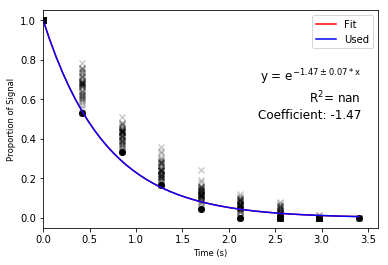

In [4]:
dat.despike(autorange_kwargs={'d_mult': 1., 'gwin': 7}, exponentplot=True)

In [5]:
dat.autorange(d_mult=1., gwin=5, on_mult=[1,.5], off_mult=[.5,4], thresh_n=3)

AutoRange:   3%|▎         | 7/273 [00:00<00:17, 14.86it/s]/Users/oscarbranson/GoogleDrive/ANU/Projects/latools/latools/latools.py:3594: UserWarning: 
Sample 1308H1-42e: Transition identification at 46.3 failed.
Please check the data plots and make sure everything is OK.
(Run 'trace_plots(ranges=True)'


  "'trace_plots(ranges=True)'\n\n"))
AutoRange: 100%|██████████| 273/273 [00:09<00:00, 30.86it/s]


In [6]:
dat.bkg_calc_weightedmean(weight_fwhm=300, n_min=35, n_max=70, cstep=100, filter=True)

Calculating Analyte Backgrounds: 100%|██████████| 10/10 [00:57<00:00,  5.84s/it]


In [7]:
# fig, ax = dat.bkg_plot()

In [8]:
dat.bkg_subtract()

Background Subtraction: 100%|██████████| 273/273 [00:16<00:00, 16.50it/s]


In [9]:
dat.ratio()

Ratio Calculation: 100%|██████████| 273/273 [00:01<00:00, 214.04it/s]


In [10]:
dat.calibrate(srms_used=['NIST610', 'NIST612'])

/Users/oscarbranson/anaconda/envs/py3/lib/python3.5/site-packages/scipy/odr/odrpack.py:394: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)
Calibration: 100%|██████████| 273/273 [00:06<00:00, 40.47it/s]


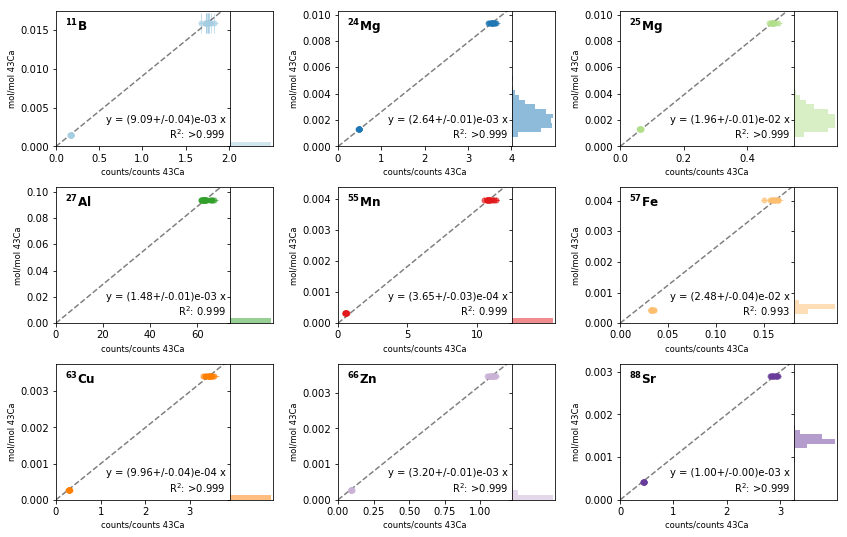

In [13]:
fig, axs = dat.calibration_plot()

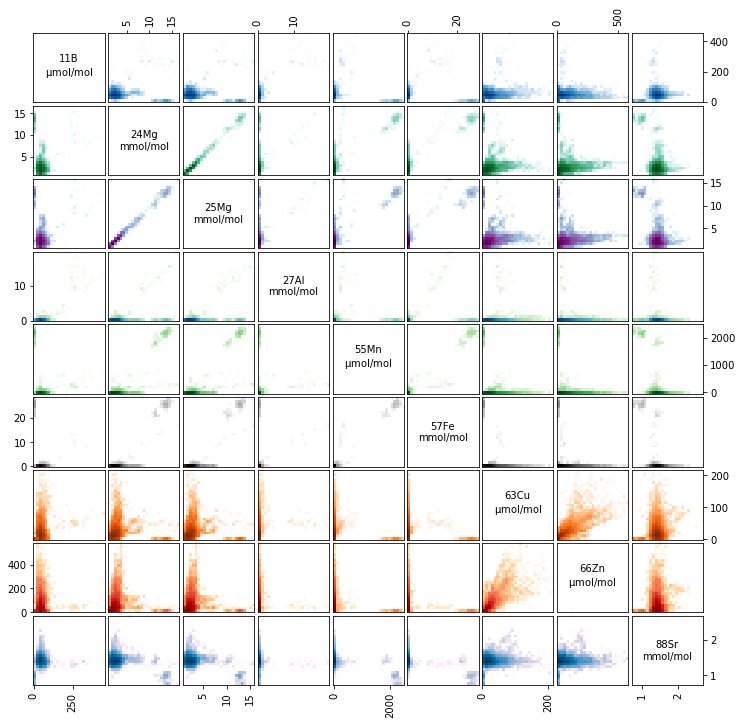

In [14]:
fig, axs = dat.crossplot()

In [30]:
dat.filter_clear()
dat.filter_threshold('27Al', 100e-6)
dat.filter_threshold('55Mn', 0.1e-3)
dat.filter_threshold('57Fe', 1e-3)
dat.filter_threshold('24Mg', 5e-3)
dat.filter_threshold('66Zn', 200e-6)
dat.filter_threshold('63Cu', 30e-6)
# dat.filter_on('below')

Threshold Filter: 100%|██████████| 248/248 [00:00<00:00, 5596.56it/s]


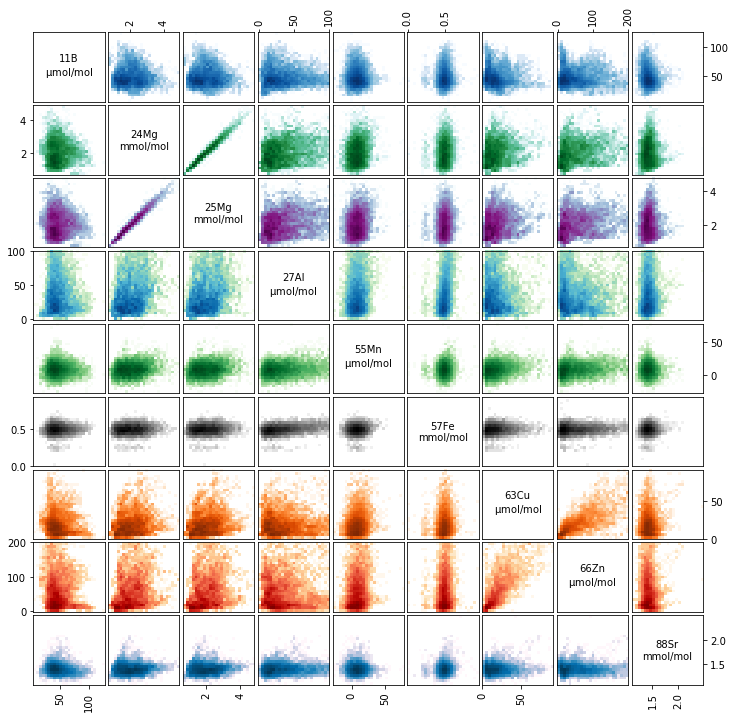

In [31]:
fig, axs = dat.crossplot(filt='Albelow & Mnbelow & Mgbelow & Znbelow')

In [48]:
dat.filter_on('Albelow & Mnbelow & Mgbelow & 66Znbelow')

Subset: All Samples

n  Filter Name           11B    24Mg   25Mg   27Al   43Ca   55Mn   57Fe   63Cu   66Zn   88Sr   
0  27Al_thresh_below     True   True   True   True   True   True   True   True   True   True   
1  27Al_thresh_above     False  False  False  False  False  False  False  False  False  False  
2  55Mn_thresh_below     True   True   True   True   True   True   True   True   True   True   
3  55Mn_thresh_above     False  False  False  False  False  False  False  False  False  False  
4  57Fe_thresh_below     False  False  False  False  False  False  False  False  False  False  
5  57Fe_thresh_above     False  False  False  False  False  False  False  False  False  False  
6  24Mg_thresh_below     True   True   True   True   True   True   True   True   True   True   
7  24Mg_thresh_above     False  False  False  False  False  False  False  False  False  False  
8  66Zn_thresh_below     True   True   True   True   True   True   True   True   True   True   
9  66Zn_thresh_abov

In [49]:
dat.sample_stats(stats=['H15_mean', 'H15_se'])

Calculating Stats: 100%|██████████| 273/273 [00:23<00:00, 11.59it/s]


In [50]:
sd = dat.getstats()
sd.reset_index(inplace=True)

fm = re.compile('(.*-[0-9]{1,2})([a-z]+)')
fms = re.compile('(.*)_(.*)')

def split(d):
    sample = d.loc[:,'sample'].iloc[0]
    if fm.match(sample):
        name, spot = fm.match(sample).groups()
    else:
        name = fms.match(sample).groups()[0]
        spot = 'a'
    
    d.loc[:, 'sample'] = name
#     d.loc[:, 'n'] = n
    d.loc[:, 'rep'] = spot
    return d

gs = sd.groupby('sample')
sd = gs.apply(split)

df = sd.pivot_table(index=('statistic', 'sample', 'rep'))

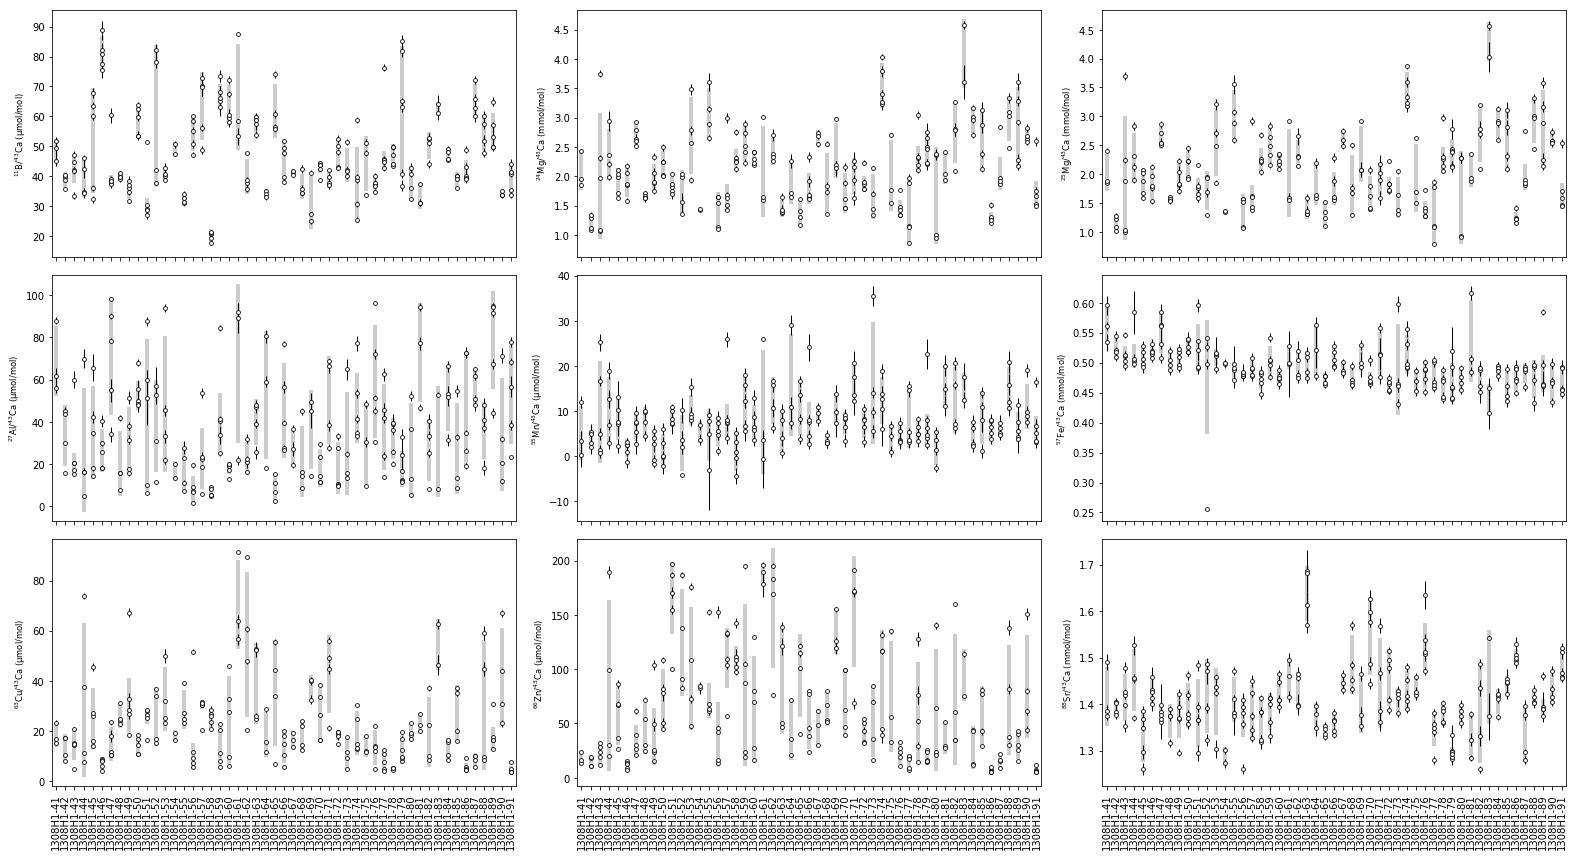

In [51]:
fig, ax = plt.subplots(3,3, figsize=[22,12], sharex=True)

val = 'H15_mean'
err = 'H15_se'

ans = dat.analytes[dat.analytes != dat.internal_standard]

rep = lambda x: x.groups()[0] + '{:02.0f}'.format(int(x.groups()[1]))

for a, ax in zip(ans, ax.flat):
    x = 0
    labs = []
    m, u = unitpicker(df.loc[idx[val,:,:],a].min())

    for s in sorted(np.unique(df.index.levels[1]), key=lambda x: re.sub('(.*[-_])([0-9]+)',rep,x)):
        d = df.loc[idx[val,s,:],a]
        de = df.loc[idx[err,s,:],a]
        xs = [x] * d.size

        if any(np.isfinite(d.values)):
            ax.scatter(xs,d.values * m, c='w', lw=0.8, edgecolor='k', s=15)
            ax.errorbar(xs, d.values * m, yerr=de.values * m,
                        lw=0, elinewidth=1, zorder=-1, color='k')

            mean = H15_mean(d.values * m)
            std = H15_std(d.values * m)
            ax.plot([x,x], [mean-std, mean+std], zorder=-2, lw=4, c=(.8,.8,.8))

            labs.append(s)
            x += 1

    ax.set_ylabel(pretty_element(a) + '/' + pretty_element(dat.internal_standard) + ' (' + u + ')')
    
    ax.set_xlim(-0.5, x - 0.5)
    
    if ax.is_last_row():
        ax.set_xticks(np.arange(x))
        ax.set_xticklabels(labs, rotation=90)

fig.tight_layout()

In [52]:
fig.savefig(dat.report_dir + '/Cleaning_RUN2_summary.pdf')